# Supplementary Figure 2

In [1]:
import polars as pl
import seaborn as sns
import polars.selectors as cs
import matplotlib.pyplot as plt
import os
sns.set_style(style='white') 

In [2]:
cd = "/data/cephfs-2/unmirrored/groups/kircher/MPRA/CaptureCMPRA/"
data = pl.read_csv(cd+"results/MPRA_analysis/CMPRA5/labeled_data_promoteroa_OA.tsv", separator="\t")
fig_dir = cd+"results/manuscript_figures/supp_figure2/"

In [5]:
# use only baited data
data = data.filter(pl.col("label") != "other - other")

# dataframe of just the bins
bins = pl.concat([data.select("left_bin", "targeted_left").rename({"left_bin": "bin", "targeted_left": "label"}),
				  data.filter(pl.col("right_bin").str.contains("null").not_())
				  .select("right_bin", "targeted_right").rename({"right_bin": "bin", "targeted_right": "label"})]).unique()
# get bin sizes
bins = bins.with_columns(coords = pl.col("bin").str.split("-")).with_columns(
	start = pl.col("coords").list.get(1).cast(pl.Int32),
	end = pl.col("coords").list.get(2).cast(pl.Int32),
).with_columns(
	size = pl.col("end") - pl.col("start")
)
paired_bins = data.filter(pl.col("right_bin").str.contains("null").not_()).with_columns(
	length1 = pl.col("left_bin").str.split("-").list.get(2).cast(pl.Int32) - pl.col("left_bin").str.split("-").list.get(1).cast(pl.Int32),
	length2 = pl.col("right_bin").str.split("-").list.get(2).cast(pl.Int32) - pl.col("right_bin").str.split("-").list.get(1).cast(pl.Int32),
).with_columns(
	total_length = pl.col("length1") + pl.col("length2")
)

## Barcodes per paired-bin

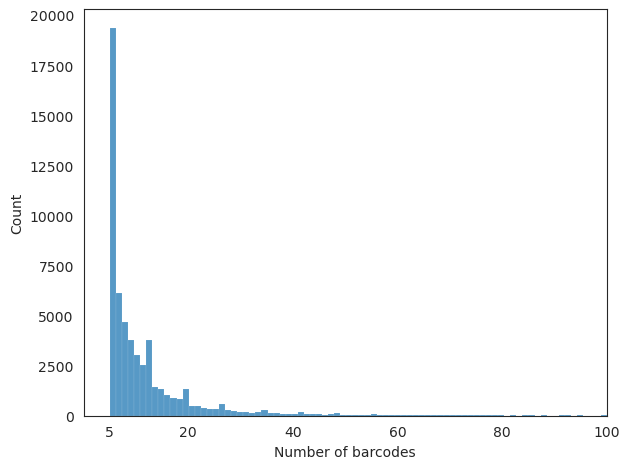

In [4]:
sns.histplot(data.filter((pl.col("promoter").is_not_null())).to_pandas(), x="nr_reads", bins=500)
plt.xlim(0,100)
plt.xlabel("Number of barcodes")
plt.xticks([5,20,40,60,80,100])
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "nr_barcodes_per_paired_bin.pdf"), format="pdf")

In [15]:
data.filter((pl.col("promoter").is_not_null())).select(mean=pl.col("nr_reads").mean(), median=pl.col("nr_reads").median(), min=pl.col("nr_reads").min(), max=pl.col("nr_reads").max())

mean,median,min,max
f64,f64,i64,i64
12.754675,8.0,5,585


## Sequences per bin

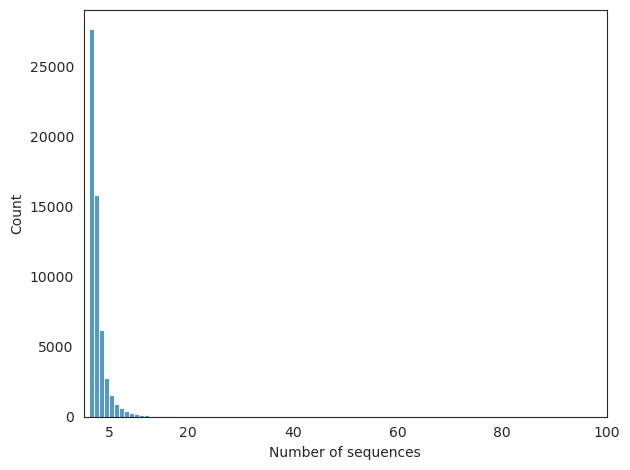

In [23]:
sns.histplot(data.filter((pl.col("promoter").is_not_null())).to_pandas(), x="nr_seqs", bins=50)
plt.xlim(0,100)
plt.xlabel("Number of sequences")
plt.xticks([5,20,40,60,80,100])
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "nr_seqs_per_paired_bin.pdf"), format="pdf")

In [24]:
data.filter((pl.col("promoter").is_not_null())).select(mean=pl.col("nr_seqs").mean(), median=pl.col("nr_seqs").median(), min=pl.col("nr_seqs").min(), max=pl.col("nr_seqs").max())

mean,median,min,max
f64,f64,i64,i64
2.149999,2.0,1,49


## Length distributions

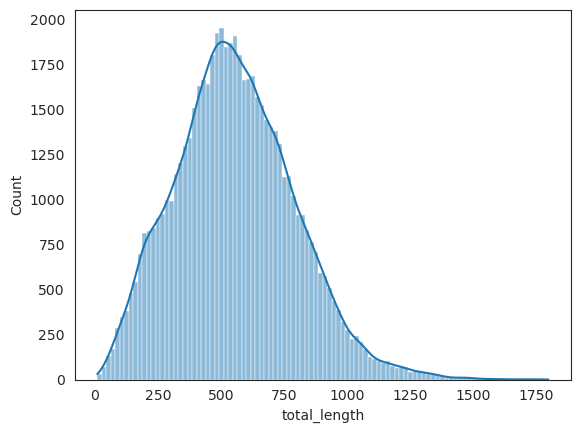

In [8]:
sns.histplot(paired_bins.to_pandas(), x="total_length", bins=100, kde=True)
plt.savefig(os.path.join(fig_dir, "bin_size_distribution.pdf"), format="pdf")

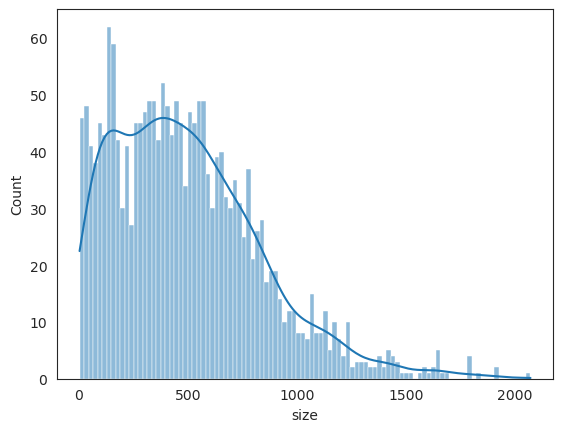

In [7]:
sns.histplot(bins.filter(pl.col("label") != "unlabeled").to_pandas(), x="size", bins=100, kde=True)
plt.savefig(os.path.join(fig_dir, "promoter_bin_size_distribution.pdf"), format="pdf")

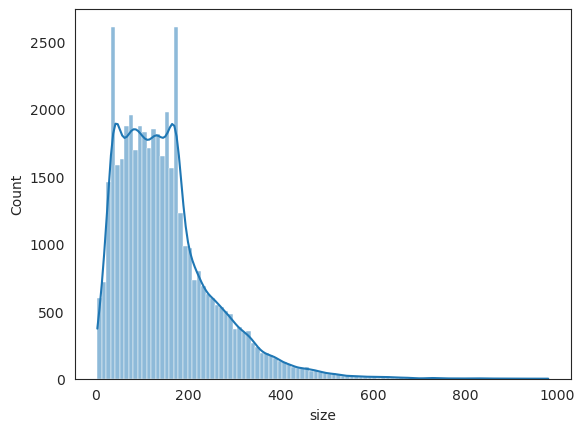

In [8]:
sns.histplot(bins.filter(pl.col("label") == "unlabeled").to_pandas(), x="size", bins=100, kde=True)
plt.savefig(os.path.join(fig_dir, "nonpromoter_bin_size_distribution.pdf"), format="pdf")

In [10]:
def print_medmean(df):
	print("\tmedian: ", df.median().to_numpy()[0][0])
	print("\tmean: ", df.mean().to_numpy()[0][0])

In [11]:
print("All bins")
print_medmean(paired_bins.select("total_length"))
print("Promoter bins")
print_medmean(bins.filter(pl.col("label") != "unlabeled").select("size"))
print("Non-promoter bins")
print_medmean(bins.filter(pl.col("label") == "unlabeled").select("size"))

All bins
	median:  545.0
	mean:  557.4326784142432
Promoter bins
	median:  446.5
	mean:  494.62577639751555
Non-promoter bins
	median:  133.0
	mean:  149.83234727572923


In [11]:
part1 = pl.read_csv("/data/humangen_kircherlab/MPRA/CaptureCMPRA/results/mprasnakeflow/results/experiments/CMPRA5/assigned_counts/fromFile/minimal/HepG2_allreps_merged.tsv.gz", separator="\t")
part2 = pl.read_csv("/data/humangen_kircherlab/MPRA/CaptureCMPRA/results/mprasnakeflow/results/experiments/CMPRA5part2/assigned_counts/fromFile/minimal/HepG2_allreps_merged.tsv.gz", separator="\t")
used_ids = pl.read_csv(os.path.join(fig_dir, "sequence_ids_le2mb_baited.tsv.gz"), separator="\t", has_header=False, new_columns=["oligo_name"])

In [12]:
part1_subset = part1#.with_columns(pl.col("oligo_name").str.strip_prefix(">")).join(used_ids, on="oligo_name")
part2_subset = part2#.with_columns(pl.col("oligo_name").str.strip_prefix(">")).join(used_ids, on="oligo_name")

In [16]:
part1.select(
	mean = pl.col("n_bc").mean(),
	median = pl.col("n_bc").median(),
	min = pl.col("n_bc").min(),
	max = pl.col("n_bc").max()
)

mean,median,min,max
f64,f64,i64,i64
4.373131,3.0,2,801


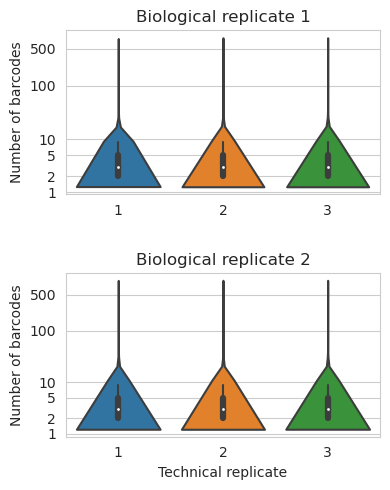

In [13]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(2,1, figsize=(4,5))
sns.violinplot(part1_subset.to_pandas(), x="replicate", y="n_bc", ax=ax[0], dodge=False)
sns.violinplot(part2_subset.to_pandas(), x="replicate", y="n_bc", ax=ax[1], dodge=False)
ax[0].set_yscale("log")
ax[0].set_ylabel("Number of barcodes")
ax[0].set_title("Biological replicate 1")
ax[0].set_xlabel(" ")

ax[1].set_yscale("log")
ax[1].set_ylabel("Number of barcodes")
ax[1].set_title("Biological replicate 2")
ax[1].set_xlabel("Technical replicate")

ax[0].set_yticks([1, 2, 5,10,100, 500])
ax[0].get_yaxis().set_major_formatter(plt.ScalarFormatter())
ax[1].set_yticks([1, 2, 5,10,100, 500])
ax[1].get_yaxis().set_major_formatter(plt.ScalarFormatter())
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "barcode_distribution.pdf"), format="pdf")


## Association barcodes per sequence

In [4]:
association_bcs = pl.read_csv("../../results/manuscript_figures/supp_figure2/assignment_bcs_per_seq.tsv.gz", 
							  separator="\t", has_header=False, new_columns=["Association barcodes", "sequence"]
							  )

In [5]:
association_bcs.head()

Association barcodes,sequence
i64,str
3,""">m84066_240516_024507_s2/10000…"
3,""">m84066_240516_024507_s2/10000…"
2,""">m84066_240516_024507_s2/10000…"
5,""">m84066_240516_024507_s2/10000…"
1,""">m84066_240516_024507_s2/10000…"


In [18]:
association_bcs.select(
	mean = pl.mean("Association barcodes"), 
	median = pl.median("Association barcodes"), 
	min = pl.min("Association barcodes"),
	 max = pl.max("Association barcodes"))

mean,median,min,max
f64,f64,i64,i64
2.67787,1.0,1,1382


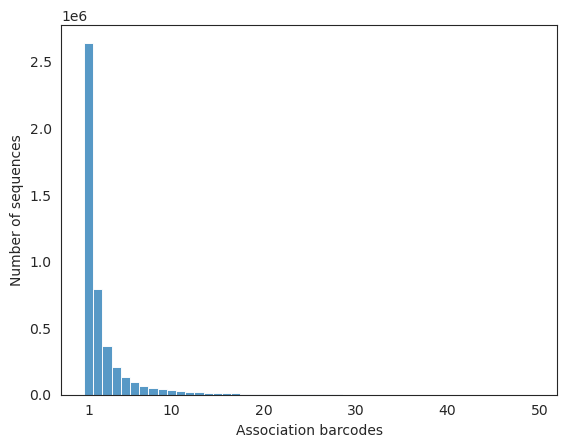

In [7]:
sns.histplot(association_bcs.to_pandas(), x="Association barcodes", bins=50, discrete=True) #, bins=100, kde=True)
plt.xticks([1, 10, 20, 30, 40, 50])	
plt.ylabel("Number of sequences")
plt.savefig(os.path.join(fig_dir,"association_barcodes_per_sequence.pdf"), format="pdf")

## Sequences per bin

In [5]:
seqcounts = pl.read_csv(os.path.join(fig_dir, "analyzed_bins_seq_counts.tsv.gz"), has_header=False)

In [6]:
seqcounts.head()

column_1
i64
1760
1487
2394
2144
113


In [13]:
print(seqcounts.min().item(), seqcounts.max().item(), seqcounts.mean().item(), seqcounts.median().item())

1 13497 90.72116887474121 33.0


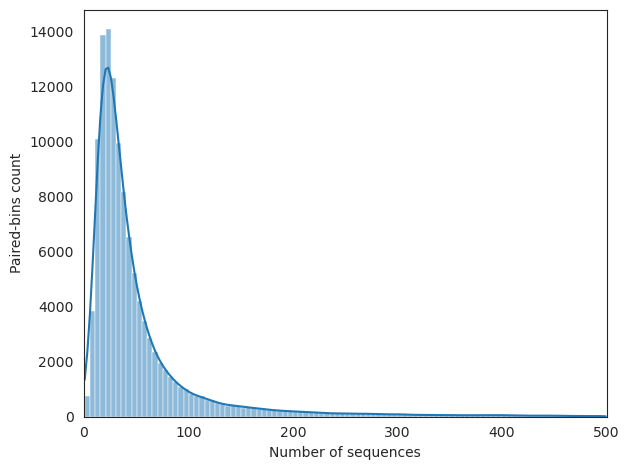

In [20]:
sns.histplot(seqcounts.filter(pl.col("column_1") < 500)
	.to_pandas(), x="column_1", bins=100, kde=True)
plt.xlim(0,500)
plt.xlabel("Number of sequences")
plt.ylabel("Paired-bins count")
plt.tight_layout()
plt.savefig(os.path.join(fig_dir, "sequence_count_per_paired_bin.pdf"), format="pdf")